In [1]:
import os
import numpy as np
import mne
import imageio
import h5py
#import scipy.fftpack
import matplotlib
%matplotlib inline
import pywt
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
#from scipy import signal
from matplotlib.colors import ListedColormap
import time
import seaborn as sns
#import scipy.io as sio
#from scipy.integrate import simps
import pandas as pd
#from scipy import fft
import matplotlib.mlab as mlab
import sys
sys.path.append('T:\EL_experiment\Codes\CCEP_human\Python_Analysis/py_functions')
import analys_func
from scipy.stats import norm
import LL_funcs
from scipy.stats import norm
from tkinter import filedialog
from tkinter import *
import ntpath
root = Tk()
root.withdraw()
import math
import scipy
from scipy import signal
import pylab
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
import platform
from glob import glob
from scipy.io import savemat

import basic_func as bf
from scipy.integrate import simps
from numpy import trapz

import tqdm
from matplotlib.patches import Rectangle


import freq_funcs as ff
subj            = "EL016"
cwd             = os.getcwd()


path_patient = 'Y:\eLab\\Patients\\'+subj

path_analysis = 'Y:\eLab\Projects\EL_experiment\Analysis\Patients\\'+subj

sep =';'    

color_elab      = ['#594157', "#F1BF98","#8FB996"]
lbls            = pd.read_excel(path_patient + "/infos/" + subj + "_labels.xlsx", header=0, sheet_name='BP')
labels_all      = lbls.label.values
labels_clinic   = lbls.Clinic.values
labels_region   = lbls.Region.values
labels_L        = lbls.Hemisphere.values
nodes           = pd.DataFrame({'ID': labels_all, 'Region': labels_region, 'H': labels_L})
coord_all       = np.array([lbls.x.values,lbls.y.values, lbls.z.values ]).T
#if subj == 'EL006':
 #     labels_all      = lbls.Clinic.values

bad_stims = np.where(labels_region=='OUT')[0]



In [2]:
Fs             = 500
dur            = np.zeros((1,2), dtype=np.int32)
t0 = 1
dur[0,0] =  -t0
dur[0,1] =  3

#dur[0,:]       = np.int32(np.sum(abs(dur)))
x_ax           = np.arange(dur[0,0],dur[0,1],(1/Fs))
color_elab      = np.zeros((4,3))
color_elab[0,:] = np.array([31, 78, 121])/255
color_elab[1,:] = np.array([189, 215, 238])/255
color_elab[2,:] = np.array([0.256, 0.574, 0.431])
cond_label = ['Pre', 'Post early', 'Post late', 'New']

## Read Data

In [3]:
prot = 'LTD1'

In [18]:
bad_chans  = pd.read_csv(path_analysis + '\\LongTermInduction\\'+prot+'\\data\\badchan.csv')
bad_chans = np.unique(np.array(np.where(bad_chans.values[:,1:]==1))[0,:])

In [320]:
files = glob(path_analysis + '\\LongTermInduction\\'+prot+'\\data\\Stim_list_*')
file = files[0]


In [7]:
EEG_resp = np.load(path_analysis + '\\LongTermInduction\\'+prot+'\\data\\All_resps_'+file[-11:-4]+'.npy')
stimlist = pd.read_csv(file)


In [14]:
def get_Stim_chans(stimlist, lbls):
    labels_all      = lbls.label.values
    labels_clinic   = lbls.Clinic.values
    labels_region   = lbls.Region.values
    coord_all       = np.array([lbls.x.values,lbls.y.values, lbls.z.values ]).T
    # get stimulation channels directly from stimlist
    StimChanSM = np.unique(stimlist.ChanP)

    ChanN = np.zeros((len(StimChanSM),))
    StimChans = []  # np.zeros((len(stim_chan)))
    StimChansC = []  # np.zeros((len(stim_chan)))
    StimChanIx = []  # np.zeros((len(stim_chan)))
    i = 0
    while i < len(StimChanSM):
        ChanN[i] = np.median(stimlist[stimlist.ChanP == StimChanSM[i]].ChanN)
        if ((np.array(lbls.ChanP_SM.values) == StimChanSM[i]) & (np.array(lbls.ChanN_SM.values) == ChanN[i])).any():
            # StimChans.append(labels_SM[(np.array(labels.chan_num.values)==stim_chan[i,0])][0])
            StimChans.append(labels_all[(np.array(lbls.ChanP_SM.values) == StimChanSM[i]) & (
                        np.array(lbls.ChanN_SM.values) == ChanN[i])][0])
            StimChansC.append(labels_clinic[(np.array(lbls.ChanP_SM.values) == StimChanSM[i]) & (
                        np.array(lbls.ChanN_SM.values) == ChanN[i])][0])
            StimChanIx.append(
                lbls[(np.array(lbls.ChanP_SM.values) == StimChanSM[i]) & (np.array(lbls.ChanN_SM.values) == ChanN[i])][
                    'Num'].values[0] - 1)
            i = i + 1
        else:
            StimChanSM = np.delete(StimChanSM, i, 0)

    stimlist = stimlist[np.isin(stimlist.ChanP, StimChanSM)]

    labels_region[labels_region == 'Temporal'] = 'Basotemporal'
    labels_region[labels_region == 'HIPP '] = 'Mesiotemporal'
    labels_region[labels_region == 'HIPP'] = 'Mesiotemporal'
    labels_region[labels_region == 'Temporal'] = 'Laterotemporal'

    return labels_all, labels_region,labels_clinic,coord_all,StimChans, StimChanSM,StimChansC, StimChanIx, stimlist

## LL and Significant responses 

In [16]:
import IO_func as IOf

In [323]:
# split condition into pre, post early, post late
LL_all.loc[(LL_all.Stim_type==1)&(LL_all.Block>1), 'Condition'] =2
LL_all.loc[(LL_all.Stim_type==0)&(LL_all.Block>10), 'Condition'] =2
LL_all.loc[(LL_all.Stim_type==1)&(LL_all.Block>3), 'Condition'] =3
LL_all.loc[(LL_all.Stim_type==0)&(LL_all.Block>15), 'Condition'] =3

In [340]:
stimlist = pd.read_csv(file)
stimlist = pd.read_csv(file)
stimlist.loc[stimlist.prot=='pre', 'condition'] = -1
stimlist.loc[stimlist.prot=='post', 'condition'] = 1
types = np.unique(stimlist.type)
for t,i in zip(types, np.arange(len(types))):
    stimlist.loc[stimlist.type ==t, 'type'] = i
# LL_all = get_LL_all_LTI(EEG_resp, stimlist, lbls, bad_chans)
stimlist = stimlist.drop(columns=['IPI_ms','Int_cond','ISI_s', 'TTL', 'TTL_DS', 'TTL_PP', 'TTL_PP_DS', 'condition', 'sleep', 'sz'])

# split condition into pre, post early, post late
LL_all.loc[(LL_all.Stim_type==1)&(LL_all.Block>1), 'Condition'] =1 # early
LL_all.loc[(LL_all.Stim_type==0)&(LL_all.Block>5), 'Condition'] =1
LL_all.loc[(LL_all.Stim_type==1)&(LL_all.Block>2), 'Condition'] =2 # post
LL_all.loc[(LL_all.Stim_type==0)&(LL_all.Block>10), 'Condition'] =2
LL_all.loc[(LL_all.Stim_type==1)&(LL_all.Block>3), 'Condition'] =3 # post
LL_all.loc[(LL_all.Stim_type==0)&(LL_all.Block>15), 'Condition'] =3
LL_all.loc[LL_all.Condition==-1, 'Condition']=0

In [24]:
lbls            = pd.read_excel(path_patient + "/infos/" + subj + "_labels.xlsx", header=0, sheet_name='BP')
labels_all, labels_region,labels_clinic,coord_all,StimChans, StimChanSM,StimChansC, StimChanIx, stimlist  = get_Stim_chans(stimlist, lbls)
bad_region = np.where((labels_region == 'WM') | (labels_region == 'OUT') | (labels_region == 'Putamen'))[0]

## Single Pulse

In [333]:
cond

array([0, 1, 2])

c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


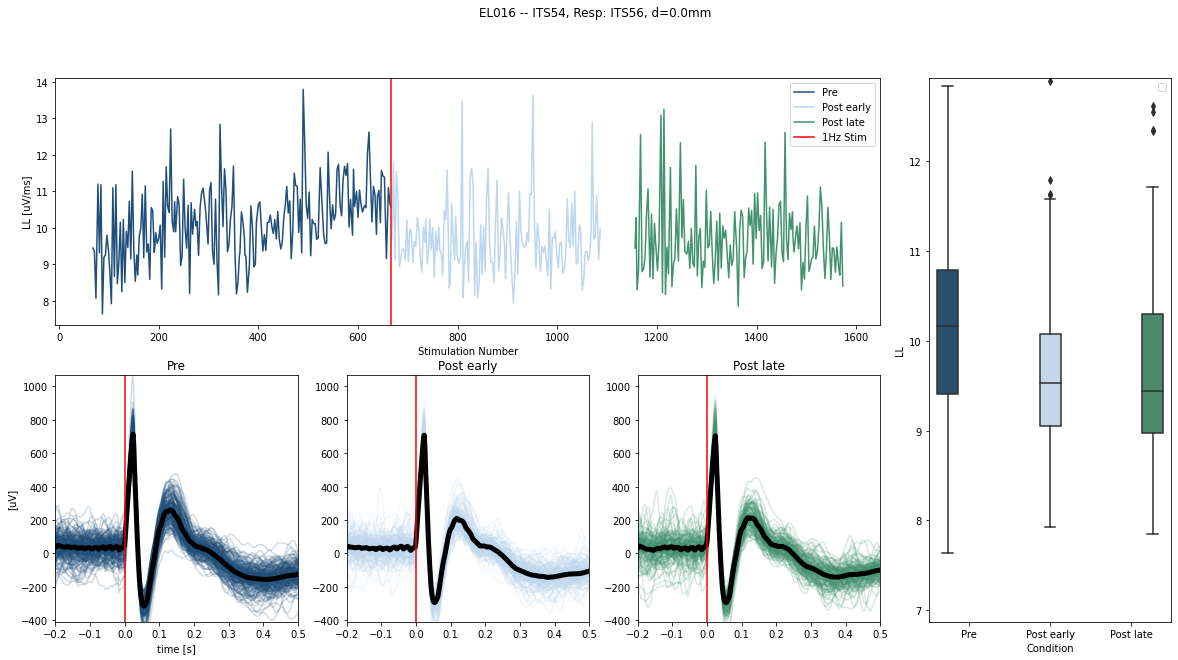

In [369]:
# select data for specific response channel (rc)
rc = 55
dat      = LL_all[(LL_all['Artefact']==0)&(LL_all['Chan']==rc)] #(LL_all['Stim']>32)& #&(LL_all['Sig_Con']>0)

datSP = dat[(dat.Condition<3)&(dat.Stim_type==1)] # only SP data
cond = np.unique(datSP.Condition).astype('int')
fig      = plt.figure(figsize=(20,10), facecolor='w', edgecolor='k')
plt.suptitle(subj+' -- '+labels_all[np.int64(sc)]+', Resp: '+labels_all[np.int64(rc)]+', d='+str(np.round(np.mean(dat.d),1))+'mm')    #
gs       = fig.add_gridspec(2,4)  # GridSpec(4,1, height_ratios=[1,2,1,2])
fig.add_subplot(gs[0, 0:3])
for c in cond:
    dat_plot = datSP[(datSP.Condition==c)]
    plt.plot(dat_plot.Num, dat_plot.LL, color=color_elab[c], label=cond_label[c])
plt.xlabel('Stimulation Number')
plt.ylabel('LL [uV/ms]')
plt.axvline(np.max(datSP.loc[(datSP.Block==1),'Num'])+0.5, color=[1,0,0], label='1Hz Stim')
plt.legend()  
ylim_mn = -200
ylim_mx = 200
for c,i in zip(cond, np.arange(len(cond))):
    fig.add_subplot(gs[1, i])
    dat_plot = datSP[(datSP.Condition==c)]
    
    for j in range(len(dat_plot.Num.values.astype('int'))):
        plt.plot(x_ax, EEG_resp[rc, dat_plot.Num.values.astype('int')[j],:],color=color_elab[c], alpha=0.2)
    plt.plot(x_ax, np.mean(EEG_resp[rc, dat_plot.Num.values.astype('int'),:],0),color=[0,0,0], linewidth=5)
    ylim_mx = np.max([ylim_mx, np.max(np.mean(EEG_resp[rc, dat_plot.Num.values.astype('int'),500:750],0))])
    ylim_mn = np.min([ylim_mn, np.min(np.mean(EEG_resp[rc, dat_plot.Num.values.astype('int'),500:750],0))])
    plt.xlim([-0.2, 0.5])
    plt.axvline(0, color=[1,0,0])
    plt.ylim([-200,200])
    if i==0:
        plt.xlabel('time [s]')
        plt.ylabel('[uV]')
    plt.title(cond_label[c])
for i in range(len(cond)):
    fig.add_subplot(gs[1, i])
    plt.ylim([1.3*ylim_mn, 1.5*ylim_mx])

fig.add_subplot(gs[:, 3])
sns.boxplot(x='Condition', y='LL', data = datSP, hue = 'Condition', palette=color_elab)    
plt.xticks(np.arange(np.max(cond)+1),cond_label[:np.max(cond)+1])
plt.ylim([0.9*np.min(datSP.LL),np.percentile(datSP.LL,99)])
plt.legend([])
plt.show()

## Input Output

### LL on mean CCEP(n=5 per block)

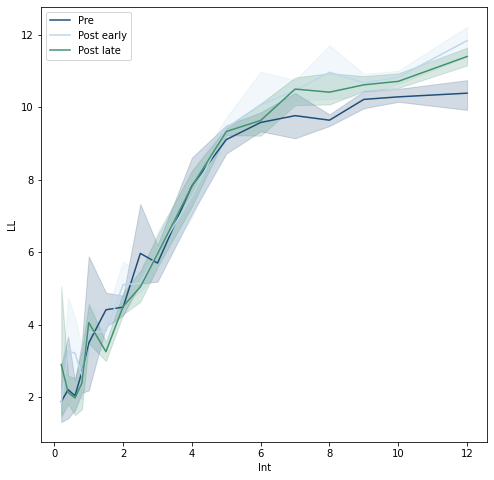

In [370]:
## mean LL of single trials LL  grouped based on condition
palette = sns.color_palette(color_elab[:3])
plt.figure(figsize=(8,8))
sns.lineplot(x='Int', y='LL', data=datIO, hue='Condition', palette = palette)
plt.legend(cond_label[:3])

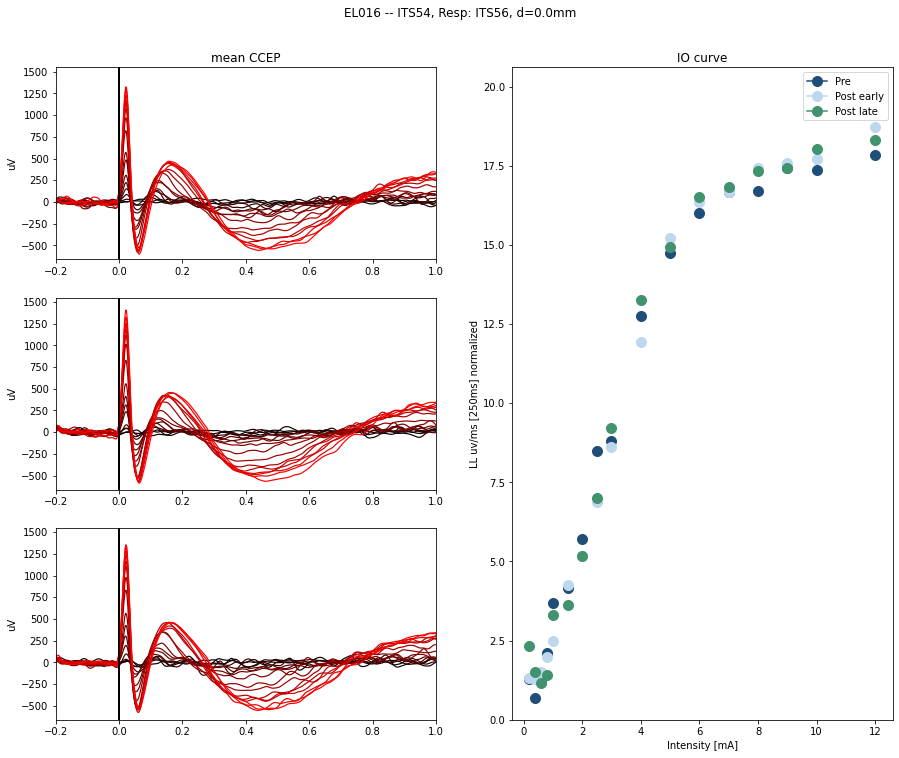

In [371]:
## LL of mean CCEP (slighlty different)
datIO = dat[(dat.Artefact==0)&(dat.Stim_type==0)&(dat.Condition<3)]
plot_raw_LL_IO_LTI(sc, rc, datIO,EEG_resp,labels_all)

In [310]:
def plot_raw_LL_IO_LTI(sc, rc, LL_all,EEG_resp,labels_all):
    dat      = LL_all[(LL_all['Stim']==sc)&(LL_all['Chan']==rc)]
    w        = 0.25
    cond = np.unique(LL_all.Condition)
    n_cond = len(cond)
    fig, axs = plt.subplots(n_cond,2, figsize=(15, 8), facecolor='w', edgecolor='k')
    axs     = axs.ravel()
    plt.close(fig) # todo: find better solution
    fig      = plt.figure(figsize=(15,n_cond*4), facecolor='w', edgecolor='k')
    #
    gs       = fig.add_gridspec(n_cond,2)  # GridSpec(4,1, height_ratios=[1,2,1,2])
    for n in range(n_cond):
        axs[n] = fig.add_subplot(gs[n, 0])

    axIO   = fig.add_subplot(gs[:, 1])
    plt.suptitle(subj+' -- '+labels_all[np.int64(sc)]+', Resp: '+labels_all[np.int64(rc)]+', d='+str(np.round(np.mean(dat.d),1))+'mm', y=0.95)
    limy_LL          = 3 # limits for LL plot
    limy_mx        = 200
    limy_mn        = -200
    Int_selc         = np.unique(dat.Int)
    colors_Int       = np.zeros((len(Int_selc), 3))
    colors_Int[:, 0] = np.linspace(0, 1, len(Int_selc))
    mx_LL =1
    for n in range(n_cond):
        Int_selc = np.unique(dat.loc[(dat.Stim==sc)&(dat.Chan==rc)&(dat.Condition==cond[n]), 'Int'])
        for i in range(len(Int_selc)):
            dati = dat[(dat.Int==Int_selc[i])&(dat.Stim==sc)&(dat.Chan==rc)&(dat.Condition==cond[n])]
            if len(dati)>0:
                resp             = ff.lp_filter(np.nanmean(EEG_resp[rc,dati.Num.values.astype('int'),: ], 0),45,Fs)
                LL_resp = LLf.get_LL_all(np.expand_dims(resp,[0,1]), Fs, 0.25, 0, np.zeros((1, 1)))[0][0]

                LL_resp             = ff.lp_filter(LL_resp,20,Fs)
                axs[n].plot( x_ax,resp, c = colors_Int[i], linewidth= 1.2)
                axs[n].set_xlim(-0.2, 0.5)
                # axs[1].plot( x_ax,LL_resp, c = colors_Int[i], linewidth= 1.2)
                mx = np.max(LL_resp[500:750])
                mx_t = np.argmax(LL_resp[500:750]) /Fs
                # axs[1].plot(mx_t,mx, marker='o', c = [0,0,0], markersize= 10)

                
                if i == len(Int_selc)-1:
                    axIO.plot(Int_selc[i], mx, marker='o', markersize=10, c = color_elab[n], label=cond_label[n])
                else:
                    axIO.plot(Int_selc[i], mx, marker='o', markersize=10, c = color_elab[n])
                limy_mx = np.nanmax([limy_mx, np.max(resp[500:750])])
                limy_mn = np.nanmin([limy_mn, np.min(resp[500:750])])
                mx_LL = np.max([mx_LL, mx])
                axs[n].axvline(0, c=[0,0,0])   
                axs[n].set_xlim(-0.2, 1)
                axs[n].set_ylabel('uV')


    axIO.set_title('IO curve')
    axIO.set_ylabel('LL uv/ms [250ms] normalized')
    axIO.set_xlabel('Intensity [mA]')
    axIO.set_ylim([0,1.1*mx_LL])
    axIO.legend()

    axs[0].set_title('mean CCEP')

    
    # axs[1].set_ylabel('uV/ms')
    for n in range(n_cond):
        axs[n].set_ylim(1.1*limy_mn,1.1*limy_mx)